<a href="https://colab.research.google.com/github/Yogesh914/ViT_paper_replication/blob/main/ViT_paper_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Research Paper Replicating

The goal is to turn a ML research paper into usable code.

In this notebook we are going to replicate the Vision Transformer (ViT) architecture/paper in pytorch: https://arxiv.org/abs/2010.11929

## 1. Setup

In [ ]:
import torch
import torchvision
import os
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


os.chdir("/content/drive/MyDrive/Colab Notebooks/")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

[INFO] Couldn't find torchinfo... installing it.


'cuda'

## 2. Data

In [ ]:
from torchvision import datasets, transforms

IMG_SIZE = (32, 32)  # CIFAR10 images are 32x32 pixels
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

# Set up the training and test datasets
train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# Create the dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get the class names
class_names = train_dataset.classes

In [ ]:
len(training_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [ ]:
img_batch, label_batch = next(iter(training_dataloader))
image, label = img_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

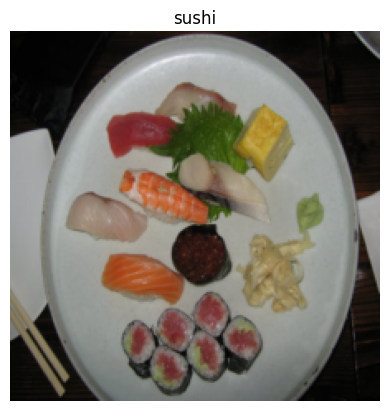

In [ ]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT Model

### Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper"/>

* Embedding = learnable representation (start with random numbers and improve over time)

1. An image is split into fixed-size patches.
2. Each patch is flattened and linearly embedded.
3. Position embeddings are added to retain positional information.
4. A special "classification token" ([class]) is appended to the sequence of embedded patches.
5. The sequence is then fed into a series of Transformer encoder layers.



* Multi-Head Attention (MHA)
* Normalization layers (Norm)
* A feed-forward neural network (MLP head)

### Four equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>

#### Section 3.1 describes the various equations:

**Equation 1: Initial Embedding of Patches**
* $\mathbf{x}_{class}$ is the embedding of the classification token.
* $\mathbf{x_p^iE}$ represents the embedding of the i-th patch, where $\mathbf{x}_{p}^{i}$ is the flattened pixel values of the i-th patch, and $\mathbf{E}$ is the patch embedding matrix.
* $\mathbf{E}_{pos}$ is the position embedding matrix, and $\mathbf{D}$ is the dimension of the embeddings.
* $\mathbf{P}$ is the height and width of a patch, $\mathbf{C}$ is the number of channels in the image, and $\mathbf{N}$ is the number of patches.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```


---

**Equations 2 and 3:**

* `MSA` stands for Multi-Head Self-Attention.
* `LN` denotes Layer Normalization.
* $\mathbf{z'}_{\ell}$ is the output from the previous layer (or the initial embedding for `l=1`).
* This equation represents the attention mechanism within the encoder, where each patch's representation is updated by attending to all other patches.

* After attention, the result goes through a feed-forward neural network (MLP).
* The output is again added to the input of this block $\mathbf{z'}_{\ell}$ to form a residual connection.

In pseudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```
---

**Equation 4:**

* $\mathbf{z}_{L}^{0}$ is the output embedding of the classification token from the last layer.
* This final layer normalized embedding is then used for classification.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```

In summary, the image is processed through a series of Transformer encoder blocks where each block updates the patch embeddings through self-attention and MLPs. The output embedding of the classification token from the last layer is used to make the final classification prediction.

### Table 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture
* ViT-Huge = image patch size 32x32
* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Heads - the number of multi-head self-attention

## 4. Equation 1

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channels)
* Output shape: ???


* Input shape: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)

In [ ]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 32

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

In [ ]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")